In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

import pandas as pd
import tensorflow as tf
from tensorflow import keras
#import numpy as np
#from matplotlib import pyplot as plt
#import seaborn as sns
#%pylab inline

## Exercise 10

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

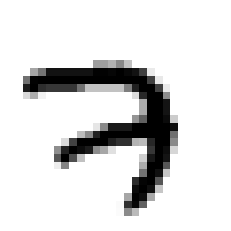

In [5]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [6]:
X_valid.shape

(5000, 28, 28)

In [7]:
X_test.shape

(10000, 28, 28)

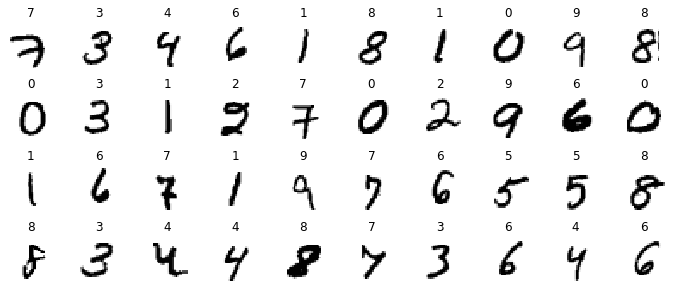

In [8]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [9]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [10]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [12]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 11s 6ms/step - loss: nan - accuracy: 0.5658 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

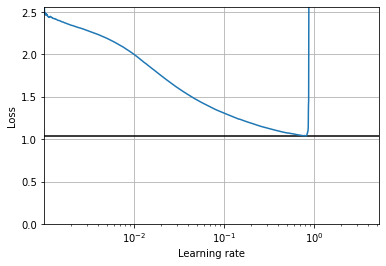

In [13]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [16]:
import os
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2362 - accuracy: 0.9266 - val_loss: 0.0978 - val_accuracy: 0.9704
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0946 - accuracy: 0.9703 - val_loss: 0.0926 - val_accuracy: 0.9730
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0664 - accuracy: 0.9787 - val_loss: 0.0827 - val_accuracy: 0.9756
Epoch 4/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0476 - accuracy: 0.9850 - val_loss: 0.0750 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.0354 - accuracy: 0.9880 - val_loss: 0.0788 - val_accuracy: 0.9784
Epoch 6/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0300 - accuracy: 0.9904 - val_loss: 0.0768 - val_accuracy: 0.9794
Epoch 7/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0807 - v

In [18]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0830 - accuracy: 0.9809


[0.08301407098770142, 0.98089998960495]

## Hyperparameter Tuning


In [23]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [26]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [27]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 6s 11ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 3s 9ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 3s 9ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 3s 8ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 3s 9ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 3s 7ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4060 - val_

In [28]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3346


In [30]:
np.random.seed(42)
tf.random.set_seed(42)


In [31]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [========

KeyboardInterrupt: ignored

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.005803602934201024, 'n_hidden': 3, 'n_neurons': 74}

In [ ]:
rnd_search_cv.best_score_

-0.31959917147954303

In [ ]:
rnd_search_cv.best_estimator_